# Task B - Facial Recognition

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Define Path

In [3]:
train_dir = '/content/drive/MyDrive/comsys-hackathon-5/Comys_Hackathon5/Task_B/train'
val_dir = '/content/drive/MyDrive/comsys-hackathon-5/Comys_Hackathon5/Task_B/val'

## Transformations

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## Embedding Pairs

In [11]:
def extract_embeddings(data_dir, model, transform):
    embeddings = {}
    for person in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person)
        if not os.path.isdir(person_path): continue

        emb_list = []
        for img_name in os.listdir(person_path):
            if img_name.endswith(".jpg"):
                img_path = os.path.join(person_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img_tensor = transform(img).unsqueeze(0)
                    with torch.no_grad():
                        emb = model(img_tensor).squeeze()
                        emb_list.append(emb)
                except:
                    continue

        distort_path = os.path.join(person_path, "Distortion")
        if os.path.exists(distort_path):
            for img_name in os.listdir(distort_path):
                if img_name.endswith(".jpg"):
                    img_path = os.path.join(distort_path, img_name)
                    try:
                        img = Image.open(img_path).convert("RGB")
                        img_tensor = transform(img).unsqueeze(0)
                        with torch.no_grad():
                            emb = model(img_tensor).squeeze()
                            emb_list.append(emb)
                    except:
                        continue

        if emb_list:
            embeddings[person] = emb_list
    return embeddings

## Create Pairs

In [12]:
def create_pairs(embeddings):
    X1, X2, y = [], [], []
    people = list(embeddings.keys())

    for i, person in enumerate(people):
        for emb1 in embeddings[person]:
            # Positive pair
            emb2 = embeddings[person][0]
            X1.append(emb1)
            X2.append(emb2)
            y.append(1)

            # Negative pair
            for j in range(len(people)):
                if i != j:
                    emb2 = embeddings[people[j]][0]
                    X1.append(emb1)
                    X2.append(emb2)
                    y.append(0)
                    break
    return X1, X2, y

## Pretrained Feature Extractor

In [13]:
def get_feature_extractor():
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Identity()
    model.eval()
    return model

## Evaluation Metrics

In [14]:
def evaluate(X1, X2, y_true):
    similarities = [F.cosine_similarity(x1.unsqueeze(0), x2.unsqueeze(0)).item() for x1, x2 in zip(X1, X2)]
    y_pred = [1 if s > 0.5 else 0 for s in similarities]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall: {rec * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix_taskB.png")
    plt.show()

    return acc, prec, rec, f1

## Main Execution Block

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


Extracting train embeddings...

[TRAIN METRICS]
Accuracy: 50.00%
Precision: 50.00%
Recall: 100.00%
F1 Score: 66.67%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1936
           1       0.50      1.00      0.67      1936

    accuracy                           0.50      3872
   macro avg       0.25      0.50      0.33      3872
weighted avg       0.25      0.50      0.33      3872



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


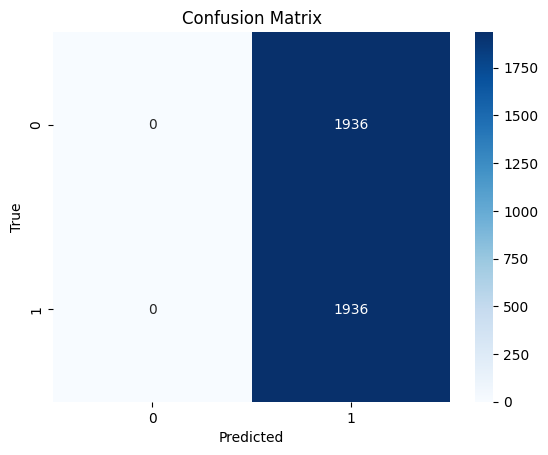

Extracting val embeddings...

[VALIDATION METRICS]
Accuracy: 50.00%
Precision: 50.00%
Recall: 100.00%
F1 Score: 66.67%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       425
           1       0.50      1.00      0.67       425

    accuracy                           0.50       850
   macro avg       0.25      0.50      0.33       850
weighted avg       0.25      0.50      0.33       850



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


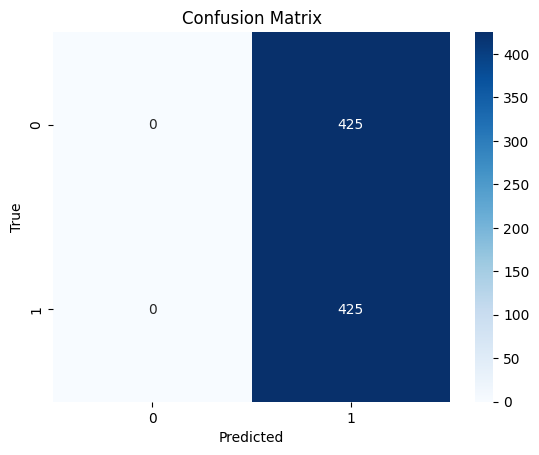

In [15]:
model = get_feature_extractor()

print("Extracting train embeddings...")
train_embeddings = extract_embeddings(train_dir, model, transform)
X1_train, X2_train, y_train = create_pairs(train_embeddings)
print("\n[TRAIN METRICS]")
train_acc, train_prec, train_rec, train_f1 = evaluate(X1_train, X2_train, y_train)


print("Extracting val embeddings...")
val_embeddings = extract_embeddings(val_dir, model, transform)
X1_val, X2_val, y_val = create_pairs(val_embeddings)
print("\n[VALIDATION METRICS]")
val_acc, val_prec, val_rec, val_f1 = evaluate(X1_val, X2_val, y_val)


## Final Summary

In [17]:
print("\n Final Summary (for submission):")
print(f"Task B Training Accuracy (%): {train_acc*100:.2f}")
print(f"Task B Training Precision (%): {train_prec*100:.2f}")
print(f"Task B Training Recall (%): {train_rec*100:.2f}")
print(f"Task B Training F1 Score (%): {train_f1*100:.2f}")
print(f"Task B Validation Accuracy (%): {val_acc*100:.2f}")
print(f"Task B Validation Precision (%): {val_prec*100:.2f}")
print(f"Task B Validation Recall (%): {val_rec*100:.2f}")
print(f"Task B Validation F1 Score (%): {val_f1*100:.2f}")


 Final Summary (for submission):
Task B Training Accuracy (%): 50.00
Task B Training Precision (%): 50.00
Task B Training Recall (%): 100.00
Task B Training F1 Score (%): 66.67
Task B Validation Accuracy (%): 50.00
Task B Validation Precision (%): 50.00
Task B Validation Recall (%): 100.00
Task B Validation F1 Score (%): 66.67
